## LangGraph tool-node, conditional-edge, loop

### Instalacja bibliotek

In [11]:
!pip install -q langgraph langchain langchain-openai python-dotenv


In [12]:
import os
from dotenv import load_dotenv
load_dotenv()

from typing import TypedDict

from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# Model LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


### Definicja stanu

In [13]:
class State(TypedDict):
    question: str
    llm_answer: str
    is_correct: bool


### Węzeł z LLM

In [14]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "Jesteś pomocnym asystentem. Odpowiadaj tylko wynikiem liczbowym."),
    ("user", "{question}")
])

def ask_llm(state: State) -> State:
    response = (prompt | llm).invoke({"question": state["question"]})
    return {"llm_answer": response.content, "is_correct": False}


### Tool node

In [15]:
def tool_calc(state: State) -> State:
    try:
        correct = eval(state["question"])  # UWAGA: w realnym projekcie zastąpić bezpiecznym parserem!
        user_answer = int(state["llm_answer"])
        return {"is_correct": (correct == user_answer)}
    except:
        return {"is_correct": False}


### Węzeł końcowy

In [16]:
def finish(state: State) -> State:
    if state["is_correct"]:
        print(f"✅ Poprawna odpowiedź: {state['llm_answer']}")
    else:
        print("❌ Nie udało się uzyskać poprawnej odpowiedzi.")
    return state


In [18]:
### Graf z połączeniem warunkowym i pętlą
graph = StateGraph(State)

graph.add_node("ask_llm", ask_llm)
graph.add_node("tool_calc", tool_calc)
graph.add_node("finish", finish)

graph.set_entry_point("ask_llm")
graph.add_edge("ask_llm", "tool_calc")

# Warunek: jeśli poprawna → finish, jeśli nie → znowu ask_llm
def check_answer(state: State):
    return "finish" if state["is_correct"] else "ask_llm"

graph.add_conditional_edges("tool_calc", check_answer, ["finish", "ask_llm"])
graph.add_edge("finish", END)

app = graph.compile()


### Uruchomienie grafu

In [19]:
app.invoke({"question": "23 * 7"})


✅ Poprawna odpowiedź: 161


{'question': '23 * 7', 'llm_answer': '161', 'is_correct': True}

### Wizualizacja grafu

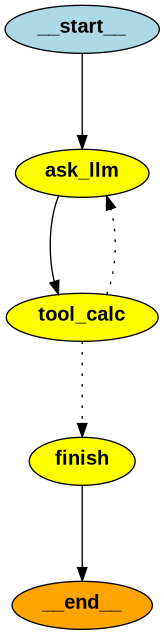

In [21]:
from IPython.display import Image, display

png_bytes = app.get_graph().draw_png()
display(Image(png_bytes))